/home/user/anaconda3/envs/rlds_env/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Visualizing data from dataset: sarc__ur5e


100%|██████████| 232/232 [10:19<00:00,  2.67s/it]  


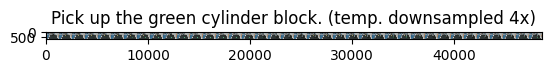

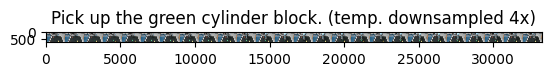

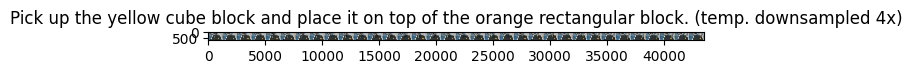

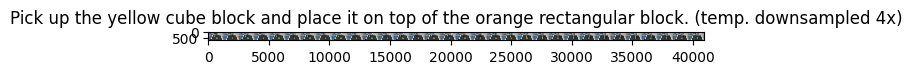

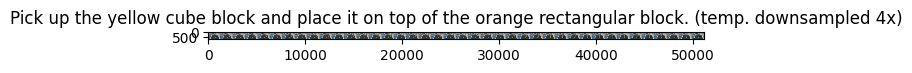

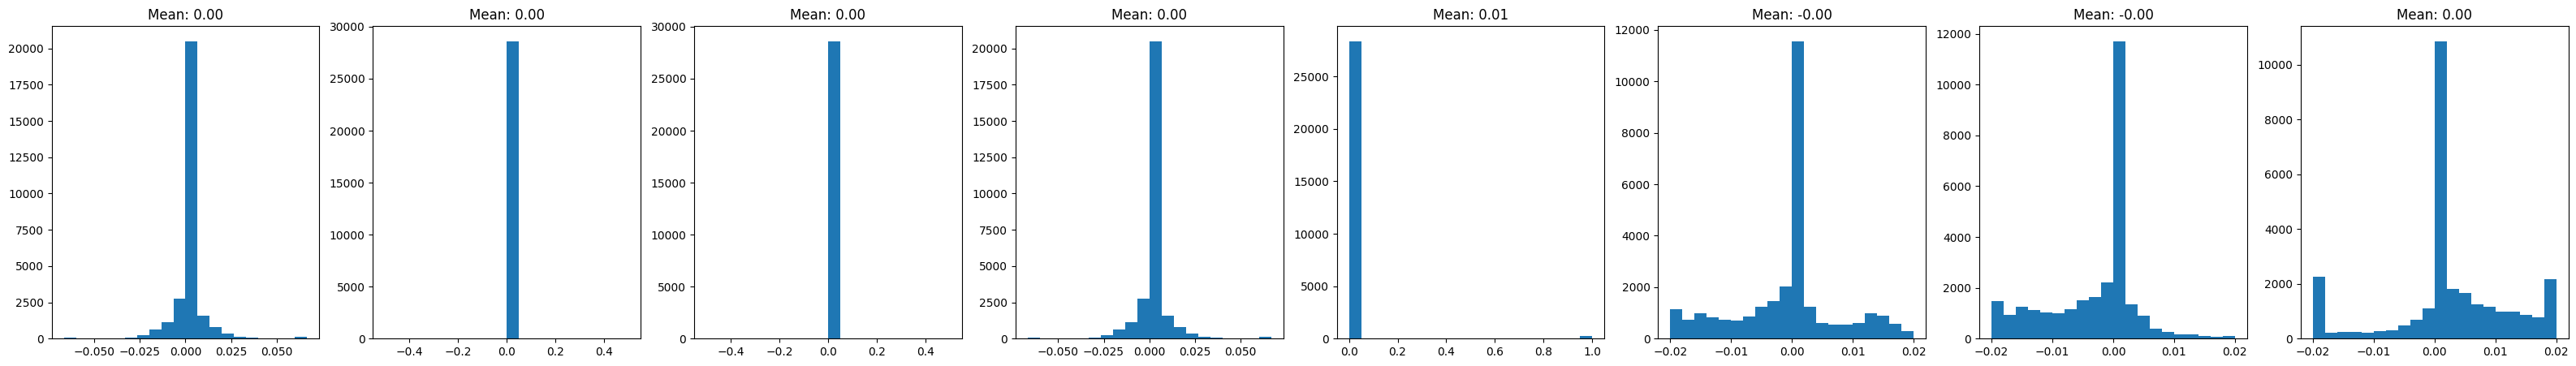

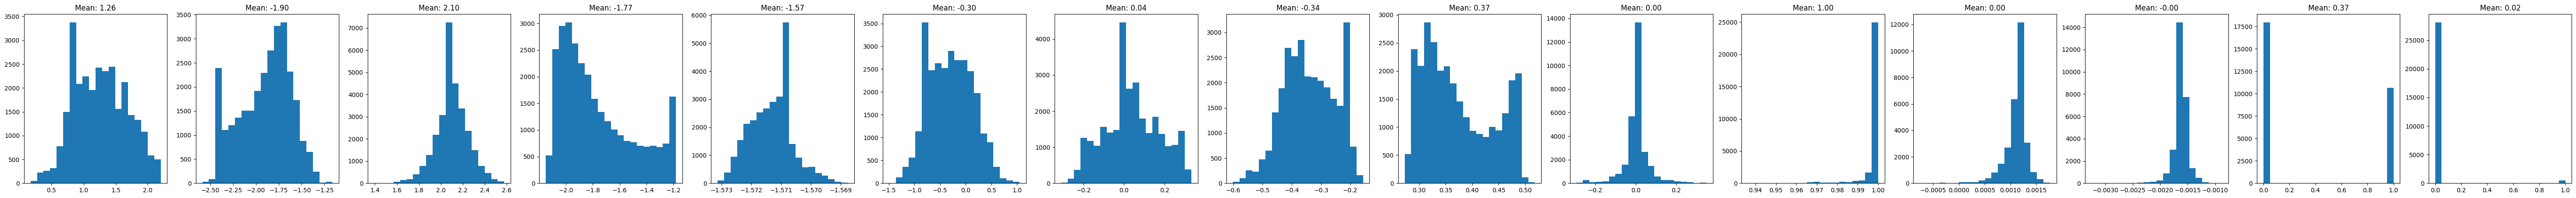

In [1]:
import argparse
import tqdm
import importlib
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # suppress debug warning messages
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
import wandb

WANDB_ENTITY = None
WANDB_PROJECT = 'vis_rlds'

if WANDB_ENTITY is not None:
    render_wandb = True
    wandb.init(entity=WANDB_ENTITY, project=WANDB_PROJECT)
else:
    render_wandb = False

# create TF dataset
dataset_name = 'sarc__ur5e'
print(f"Visualizing data from dataset: {dataset_name}")
ds = tfds.load(dataset_name, split='train')
ds = ds.shuffle(100)

# visualize episodes
for i, episode in enumerate(ds.take(5)):
    images = []
    for step in episode['steps']:
        images.append(step['observation']['image'].numpy())
    image_strip = np.concatenate(images[::4], axis=1)
    caption = step['observation']['natural_language_instruction'].numpy().decode() + ' (temp. downsampled 4x)'

    if render_wandb:
        wandb.log({f'image_{i}': wandb.Image(image_strip, caption=caption)})
    else:
        plt.figure()
        plt.imshow(image_strip)
        plt.title(caption)

# visualize action and state statistics
actions, states = [], []
for episode in tqdm.tqdm(ds.take(500)):
    for step in episode['steps']:
        action = step['action']
        concatenated_action = np.concatenate([
            [action['gripper_closedness_action'].numpy()],
            action['rotation_delta'].numpy(),
            [action['terminate_episode'].numpy()],
            action['world_vector'].numpy()
        ])
        actions.append(concatenated_action)
        states.append(step['observation']['robot_state'].numpy())
actions = np.array(actions)
states = np.array(states)
action_mean = actions.mean(0)
state_mean = states.mean(0)

def vis_stats(vector, vector_mean, tag):
    assert len(vector.shape) == 2
    assert len(vector_mean.shape) == 1
    assert vector.shape[1] == vector_mean.shape[0]

    n_elems = vector.shape[1]
    fig = plt.figure(tag, figsize=(5*n_elems, 5))
    for elem in range(n_elems):
        plt.subplot(1, n_elems, elem+1)
        plt.hist(vector[:, elem], bins=20)
        plt.title(f'Mean: {vector_mean[elem]:.2f}')

    if render_wandb:
        wandb.log({tag: wandb.Image(fig)})

vis_stats(actions, action_mean, 'action_stats')
vis_stats(states, state_mean, 'state_stats')

if not render_wandb:
    plt.show()
